# STPB_LSTM_WITH_CLASS

In [1320]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1321]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [1322]:
import statsmodels.api as sm
import statslib as stb
import tensorflow as tf
import seaborn as sns

In [1323]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [1324]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [1325]:
from gmt.fom.gas.shared.models.short_term_power_burn.stpb import MongoAdapter

In [1326]:
figsize=(9*1.6, 9)

In [1327]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [1328]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [1329]:
YEARS = 4

In [1330]:
FORECAST_HORIZON = 1; FORECAST_HORIZON

1

In [1331]:
INPUT_WIDTH = 50; INPUT_WIDTH 

50

# DATA

In [1332]:
myData = MongoAdapter()
data = myData.load_design_matrix()

In [1333]:
#<------- TRAIN --------- VALIDATION -------- TEST -------->

In [1334]:
train_up_to_idx = data.index.min() + DateOffset(years=YEARS)
train_idx = data.truncate(after=train_up_to_idx).index

In [1335]:
pred_idx = data[-(2*INPUT_WIDTH+FORECAST_HORIZON):-FORECAST_HORIZON].index

In [1336]:
out_t_idx = data[-FORECAST_HORIZON:].index

In [1337]:
val_idx = sorted(set(data.index).difference(set(train_idx).union(pred_idx).union(out_t_idx)))

In [1338]:
print(f'train_idx={len(train_idx)}\nval_idx={len(val_idx)}\npred_idx={len(pred_idx)}\nout_t_idx={len(out_t_idx)}')

train_idx=1462
val_idx=307
pred_idx=100
out_t_idx=1


In [1339]:
assert len(train_idx)+len(val_idx)+len(pred_idx)+len(out_t_idx)==data.shape[0]

In [1340]:
#Enrich for Design Matrix

In [1341]:
#fourier series
K = 3
data = data.join(get_fourier_series(data.index,K))

In [1342]:
dependent_var = ['gas']; dependent_var
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind']
fourier_cols =  [k for k in data if k.startswith('S') or k.startswith('C')]

In [1343]:
y = data[dependent_var]; f = stb.transforms.identical();
gs = dict()
g1 = stb.transforms.identical();
gs.update(dict(zip(covariates, [g1]*len(covariates))))
g2 = stb.transforms.identical()
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
X = data[covariates  + fourier_cols ]; 

In [1344]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=False)

In [1345]:
train_df = DM.dm.loc[train_idx].drop('y', axis=1).rename(columns=DM.names)
val_df = DM.dm.loc[val_idx].drop('y', axis=1).rename(columns=DM.names)
pred_df =DM.dm.loc[pred_idx].drop('y', axis=1).rename(columns=DM.names)
out_df =DM.dm.loc[out_t_idx].drop('y', axis=1).rename(columns=DM.names)

In [1346]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std

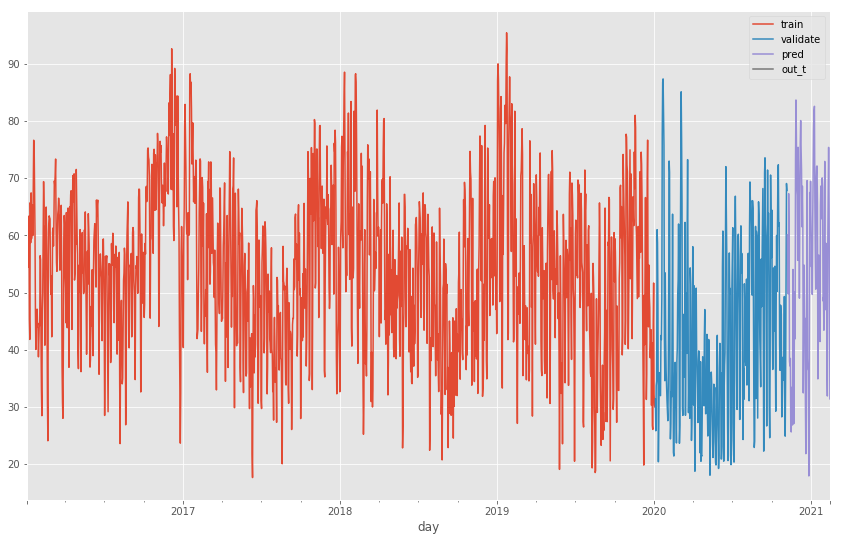

In [1347]:
fig, ax = plt.subplots(figsize=figsize)
DM.y.loc[train_idx].plot(ax=ax)
DM.y.loc[val_idx].plot(ax=ax)
DM.y.loc[pred_idx].plot(ax=ax)
DM.y.loc[out_t_idx].plot(ax=ax)
plt.legend(['train', 'validate', 'pred', 'out_t'])
plt.show()

# STANDARDIZATION OF FEATURES

In [1348]:
train_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-01-03,-1.697426,-0.271198,-1.159558,-0.518133,-0.679771,0.980831,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


In [1349]:
val_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-01-04,-1.599593,-0.271198,-1.159558,-0.764528,-0.753444,0.37391,5.872145e-14,1.415182,1.153151e-13,1.415182,-1.464933e-13,1.415182


In [1350]:
val_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-11-05,0.998194,1.07068,0.483457,-0.854557,-0.438918,-0.831384,-1.377814,-0.313725,0.613185,-1.273196,1.104921,0.882715


In [1351]:
pred_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-11-06,0.445451,1.07068,0.483457,-0.868772,-0.525814,-0.831384,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


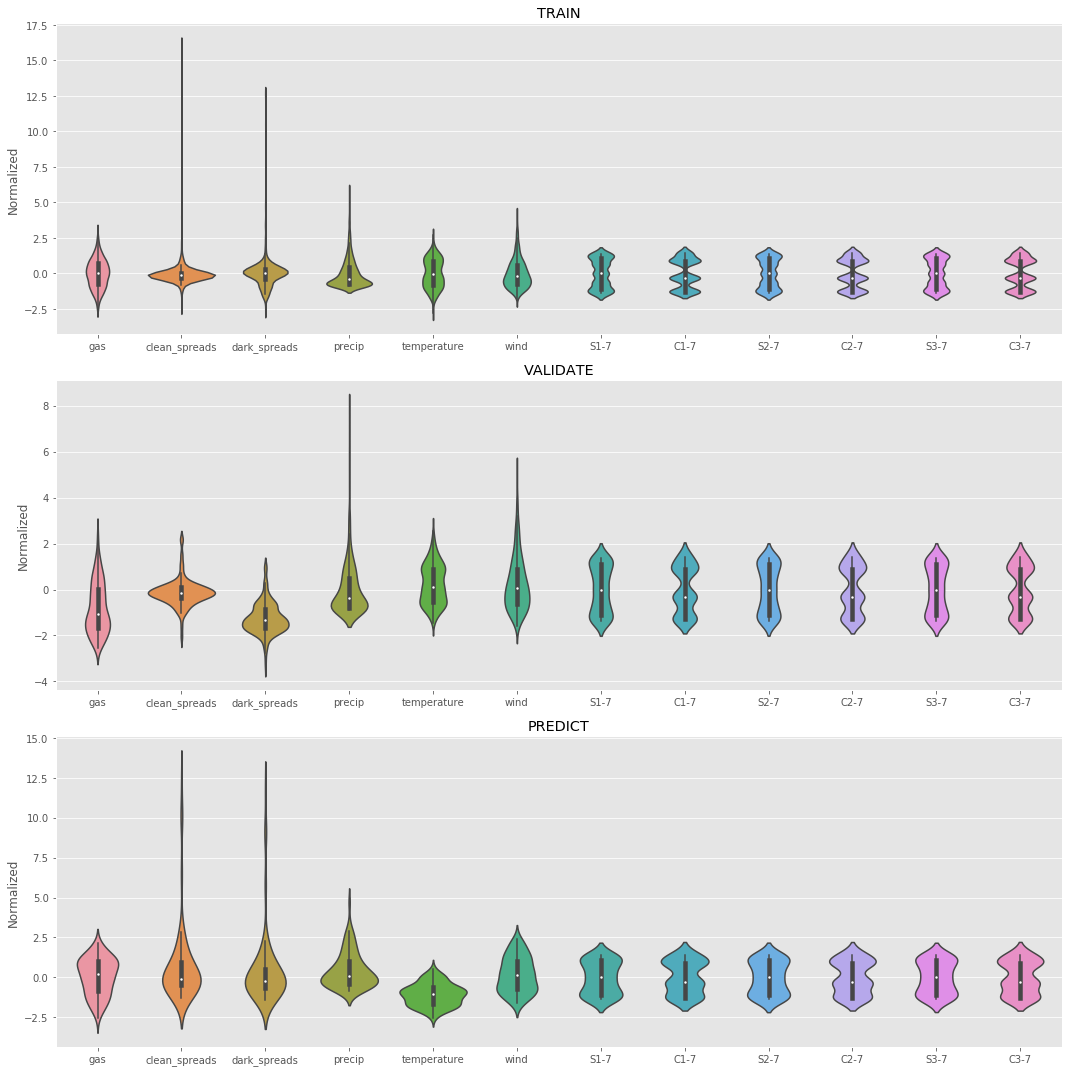

In [1352]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
_ = train_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax1)
_ = val_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax2)
_ = pred_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax3)
ax1.set_title('TRAIN')
ax2.set_title('VALIDATE')
ax3.set_title('PREDICT')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
plt.tight_layout()
plt.show()

# WINDOWS GENERATOR

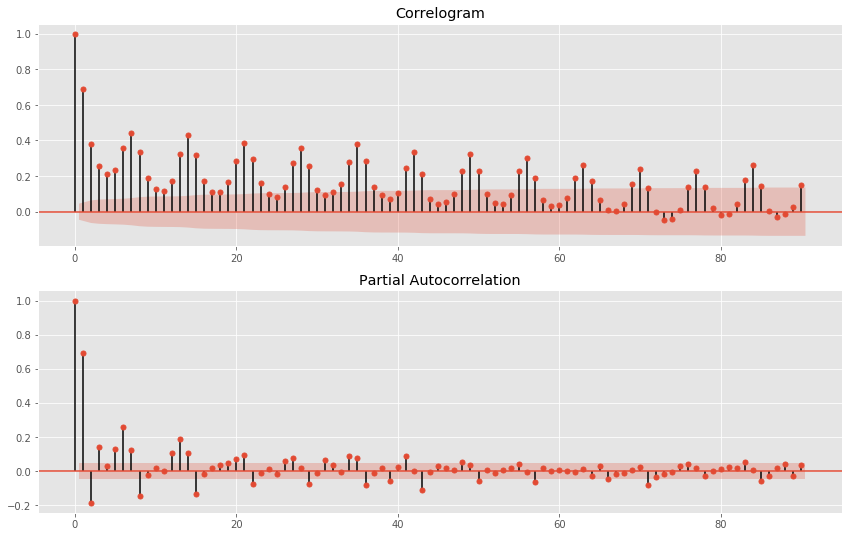

In [1353]:
stb.stat_plots.plot_acf_pcf(y, kwargs_acf=dict(lags=90), kwargs_pacf=dict(lags=90))

In [1388]:
INP_W = 10
OUT_W = 2
BATC_S = 7

In [1389]:
window = stb.WindowGenerator(
                         input_width=INP_W,
                         label_width=OUT_W,
                         shift=OUT_W,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=pred_df,
                         label_columns=['gas'])

In [1390]:
window

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11]
Label column name(s): ['gas']

In [1391]:
window.config(shuffle=False, batch_size=BATC_S)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 7}


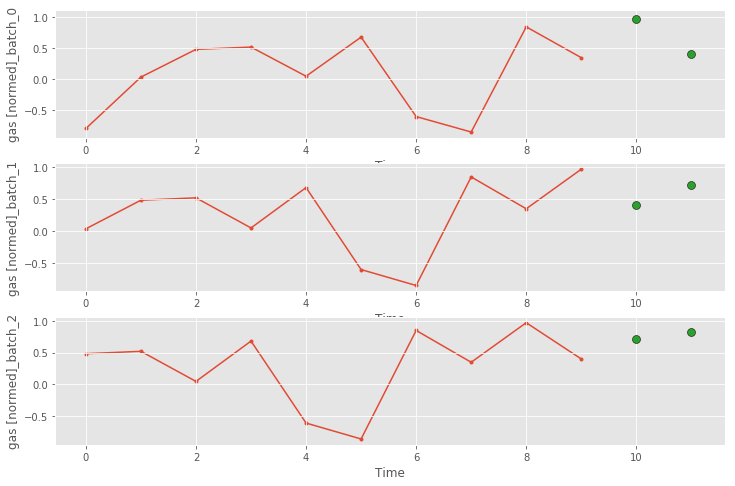

In [1392]:
window.plot('gas')

# Long Short Term Memory RNN

In [1393]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(units=64, activation='relu',return_sequences=True),
    tf.keras.layers.LSTM(units=32, activation='relu',return_sequences=False),
    tf.keras.layers.Dense(units=OUT_W)
])

In [1398]:
print('Input shape (batch_size, input_days, num_features):', window.example[0].shape)
print('Output shape (batch_size, output_days):', lstm_model(window.example[0]).shape)

Input shape (batch_size, input_days, num_features): (7, 10, 12)
Output shape (batch_size, output_days): (7, 2)


In [1399]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=4, learning_rate=5e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [1400]:
history = compile_and_fit(lstm_model,window)

Epoch 1/200
208/208 [==============================] - 3s 6ms/step - loss: 0.7943 - mean_squared_error: 0.7943 - val_loss: 1.4653 - val_mean_squared_error: 1.4653
Epoch 2/200
208/208 [==============================] - 1s 5ms/step - loss: 0.5922 - mean_squared_error: 0.5922 - val_loss: 0.8687 - val_mean_squared_error: 0.8687
Epoch 3/200
208/208 [==============================] - 1s 6ms/step - loss: 0.4245 - mean_squared_error: 0.4245 - val_loss: 0.8713 - val_mean_squared_error: 0.8713
Epoch 4/200
208/208 [==============================] - 1s 6ms/step - loss: 0.4205 - mean_squared_error: 0.4205 - val_loss: 0.8951 - val_mean_squared_error: 0.8951
Epoch 5/200
208/208 [==============================] - 1s 5ms/step - loss: 0.4697 - mean_squared_error: 0.4697 - val_loss: 0.8917 - val_mean_squared_error: 0.8917
Epoch 6/200
208/208 [==============================] - 1s 5ms/step - loss: 0.3681 - mean_squared_error: 0.3681 - val_loss: 0.9035 - val_mean_squared_error: 0.9035


2021-04-07 08:18:26,242: tensorflow: 126: WARNING: 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001CDDA6FD828> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details..


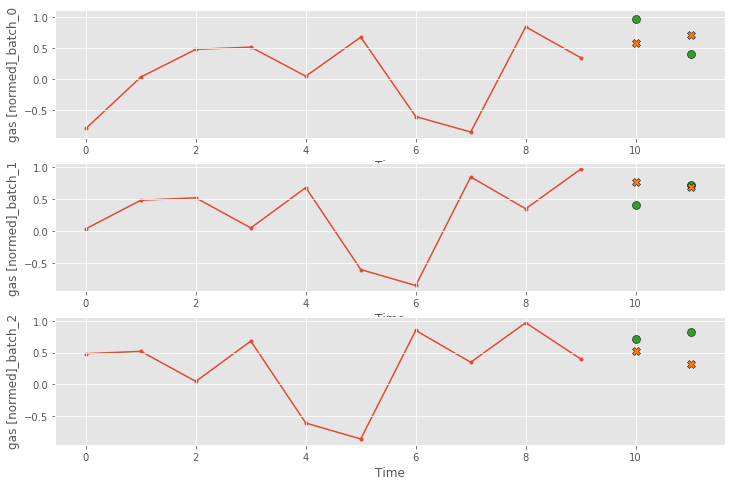

In [1401]:
res = window.plot('gas', model=lstm_model)

In [1403]:
w_pred = stb.WindowGenerator(
            input_width=INP_W,
            label_width=0,
            shift=0,
            train_df=pred_df.head(INP_W),
            val_df=None,
            test_df=None,
            label_columns=['gas'])

w_pred.config(shuffle=False, batch_size=1)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


In [1404]:
fl(lstm_model.predict(w_pred.train))

2021-04-07 08:18:55,627: tensorflow: 126: WARNING: 5 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001CDDA6FD828> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details..


[-0.6215878, -0.008291207]

In [1405]:
fl = stb.utils.common.flatten_lst

In [1406]:
idx = pred_df.shift(INP_W).dropna().head(OUT_W).index; idx

DatetimeIndex(['2020-11-16', '2020-11-17'], dtype='datetime64[ns]', name='day', freq=None)

In [1407]:
predicted = fl(lstm_model.predict(w_pred.train)); predicted

[-0.6215878, -0.008291207]

In [1408]:
v_hat = pd.Series(predicted, index=idx); v_hat

day
2020-11-16   -0.621588
2020-11-17   -0.008291
dtype: float64

In [1409]:
v = pred_df.loc[idx]['gas']; v

day
2020-11-16   -1.453693
2020-11-17   -1.770018
Name: gas, dtype: float64

In [1410]:
y_hat = v_hat*train_std['gas']+train_mean['gas']; y_hat

day
2020-11-16    45.124284
2020-11-17    53.735931
dtype: float64

In [1411]:
y = DM.dm.loc[y_hat.index]['y']; y

day
2020-11-16    33.440217
2020-11-17    28.998524
Name: y, dtype: float64

In [1412]:
print(f'Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')

Error=19.3450


In [1413]:
metric = stb.metrics.root_mean_squared_error

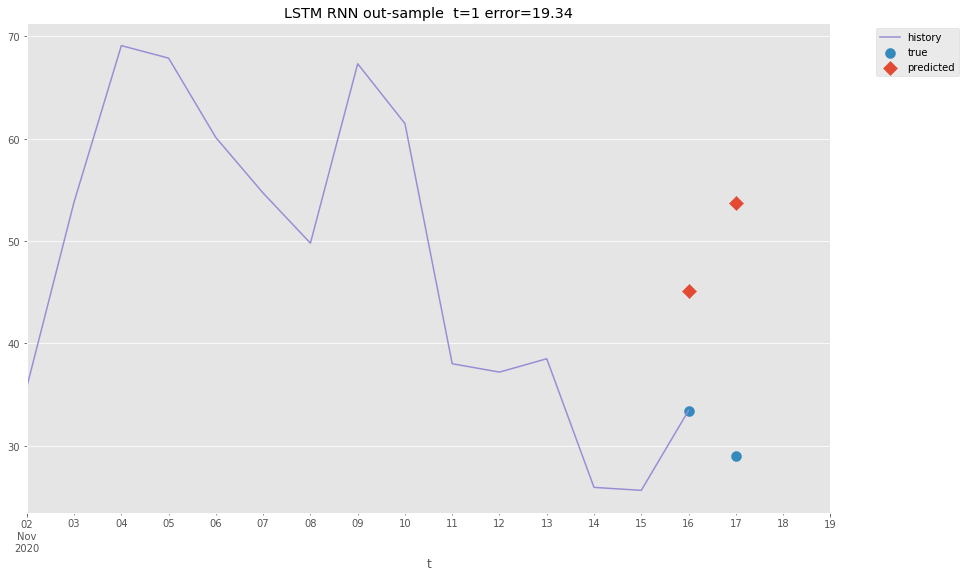

In [1414]:
out_of_sample_error = metric(y, y_hat)

fig, ax =plt.subplots(figsize=figsize)
DM.dm.truncate(after=y_hat.index.min()).iloc[-int(15):]['v'].plot(ax=ax, 
                                        color=stb.utils.plots.get_standard_colors()[2])
# y.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[1])
# y_hat.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[0])

ax.scatter(y.index, y.values, 100, color=stb.utils.plots.get_standard_colors()[1])
ax.scatter(y_hat.index, y_hat.values, 100, marker='D', color=stb.utils.plots.get_standard_colors()[0])


ax.legend(['history', 'true', 'predicted'], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(right=y.index.max() + DateOffset(days=2))

plt.title(f'ForecastHorizon={OUT_W}days | Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')
title = f'LSTM RNN out-sample  t={FORECAST_HORIZON} error={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()